In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import optuna 
import pandas as pd
import copy
import os
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import PyTorchLightningPruningCallback
from argparse import ArgumentParser
sys.path.append('../')
sys.path.append('../data/ml_mmrf')
sys.path.append('../data/')
from ml_mmrf.data import load_mmrf
from synthetic.synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from models.sfomm import SFOMM
from models.utils import *
from models.fomm import FOMM
from models.ssm.ssm import SSM
from scipy.stats import norm

In [2]:
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 

color_dict = {
    'Baseline' : 'blue',
    'LuPTS'    : 'red',
    'Stat-LuPTS': 'black',
    'MLP'      : 'orange'
} 
marker_dict = {
    'Baseline' : 's',
    'LuPTS'    : 'o',
    'Stat-LuPTS': 'D',
    'MLP'      : 'p'
}

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']) # Set the default color cycle
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 18

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## A] Data Setup

In [ ]:
fold = 1
data_dir = 'data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_trt_resp_ind_seed10.pkl'
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              data_dir=data_dir, \
                              restrict_markers=[], \
                              add_syn_marker=True, \
                              window='first_second', \
                              data_aug=False, \
                              ablation=False, \
                              feats=[])

In [4]:
X = np.concatenate((ddata[fold]['train']['x'],ddata[fold]['valid']['x'],ddata[fold]['test']['x']),axis=0)
B = np.concatenate((ddata[fold]['train']['b'],ddata[fold]['valid']['b'],ddata[fold]['test']['b']),axis=0)
Y = np.concatenate((ddata[fold]['train']['ys_seq'],ddata[fold]['valid']['ys_seq'],ddata[fold]['test']['ys_seq']),axis=0)
A = np.concatenate((ddata[fold]['train']['a'],ddata[fold]['valid']['a'],ddata[fold]['test']['a']),axis=0)
M = np.concatenate((ddata[fold]['train']['m'],ddata[fold]['valid']['m'],ddata[fold]['test']['m']),axis=0)
CE = np.concatenate((ddata[fold]['train']['ce'],ddata[fold]['valid']['ce'],ddata[fold]['test']['ce']),axis=0)
pids = np.concatenate((ddata[fold]['train']['pids'],ddata[fold]['valid']['pids'],ddata[fold]['test']['pids']),axis=0)
print(X.shape)
print(B.shape) 
print(ddata[fold]['train']['feature_names_x'])
print(ddata[fold]['train']['feature_names'])
print(ddata[fold]['train'].keys())

(379, 36, 17)
(379, 16)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'syn_marker']
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
dict_keys(['pids', 'x', 'm', 'feature_names_x', 'ys_seq', 'ce', 'feature_names_y', 'b', 'feature_names', 'a', 'm_a', 'feature_names_a'])


## B] Model Definition

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

class LUPTSRegressor():
    def __init__(self, state_estimator=None, outcome_estimator=None, stationary=True, num_states=-1):        
        if not stationary and num_states == -1: 
            raise ValueError('need to provide non-negative number of states.')
        self.trained = False
        self.stationary = stationary
        if state_estimator is None and stationary:
            self.state_estimator = LinearRegression(fit_intercept=False)
        elif state_estimator is None and not stationary: 
            self.state_estimator = [LinearRegression(fit_intercept=False) for _ in range(num_states)]
        else:
            self.state_estimator = state_estimator
        if not stationary and not isinstance(self.state_estimator, list):
            raise Exception('state_estimator must be a list of estimators for non-stationary setup')
        if outcome_estimator is None:
            self.outcome_estimator = LinearRegression()
        else:
            self.outcome_estimator = outcome_estimator
        
    def fit(self, Xs, y, B=None):
        if not isinstance(Xs, list):
            raise Exception('Xs must be a list of dataframes or 2D arrays')
            
        X1 = Xs[0]
        m = X1.shape[0]
        d = X1.shape[1]
        self.T = len(Xs)
        if not self.stationary: 
            assert self.T-1 == len(self.state_estimator), 'number of estimators not equivalent to T-1'
        XT = Xs[-1]
        
        if self.T > 1:
            self.fit_state_(Xs, B)
        self.fit_outcome_(XT, y, B)
        self.trained = True
        
        return self
                
    def fit_state_(self, Xs, B=None):
        if self.stationary: 
            inp = np.concatenate(Xs[:-1], axis=0)
            if B is not None: 
                base_cat = np.repeat(B,len(Xs)-1,axis=0)
                inp = np.concatenate([inp,base_cat],axis=-1)
            out = np.concatenate(Xs[1:], axis=0)
            self.Mz = self.state_estimator.fit(inp, out)
        else: 
            self.Mz = []
            for i,estimator in enumerate(self.state_estimator): 
                inp = Xs[i]; out = Xs[i+1]
                self.Mz.append(estimator.fit(np.concatenate([inp,B],axis=-1),out))
            
    def fit_outcome_(self, X, y, B=None):
        if B is not None: 
            X = np.concatenate([X,B],axis=-1)
        self.My = self.outcome_estimator.fit(X, y.ravel())
    
    def predict(self, X, B=None):
        if not self.trained:
            raise Exception('Model not yet fit to data')
        Z = X
        if B is not None: 
            Z = np.concatenate([X,B],axis=-1) 
        for t in range(self.T-1):
            if self.stationary: 
                Z = self.Mz.predict(Z)
            else: 
                Z = self.Mz[t].predict(Z)
            if B is not None: 
                Z = np.concatenate([Z,B],axis=-1) 
            
        y = self.My.predict(Z)
        
        return y

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def NonLinearCV(ty='classifier'):
    """
    Setup cross validation for Random Forest
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [5, 7, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [15, 20]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    if ty == 'classifier': 
        rf = RandomForestClassifier()
    else: 
        rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)
    return rf_random

def evaluate(model, X, Y):
    y_pred       = model.predict(X)
    y_pred_probs = model.predict_proba(X)
    
    roc_auc  = roc_auc_score(Y, y_pred_probs[:,1])
    accuracy = accuracy_score(Y, y_pred) 
    print("--- Accuracy: %.2f%% ---" % (accuracy * 100.0))
    print("--- AUC ROC: %.2f ---" % (roc_auc))
    print ("--- Confusion Matrix ---")
    print (confusion_matrix(Y, y_pred, labels=[0,1]))

def evaluate_multiclass(model, X, Y):
    y_pred       = model.predict(X)
    accuracy = accuracy_score(Y, y_pred) 
    print("--- Accuracy: %.2f%% ---" % (accuracy * 100.0))
    print ("--- Confusion Matrix ---")
    print (confusion_matrix(Y, y_pred, labels=[0,1,2,3]))
  

## C] Splitting, Training, and Evaluation (5x2cv)

In [7]:
def get_pts(Xtrain, Atrain, include_first_line=False): 
    # construct two sets of lists (first will be diffs and second will be raw values)
    Xs1 = []; Xs2 = []
    
    ## after first line
    Xfl = np.zeros_like(Xtrain[:,0,:])
    Xfl2= np.zeros_like(Xtrain[:,0,:])
    for i in range(Xfl.shape[0]): 
        trts = Atrain[i,:,-3]
        idxs = np.where(trts == 1.)[0]
        st = idxs[0]; end = idxs[-1]
        Xfl[i] = Xtrain[i,end,:]-Xtrain[i,st,:]
        Xfl2[i]= Xtrain[i,end,:]
    
    if include_first_line: 
        X1a = np.concatenate((Xtrain[:,0,:],Xfl),axis=-1)
        X1b = np.concatenate((Xtrain[:,0,:],Xfl2),axis=-1)
        Xs1.append(X1a); Xs2.append(X1b)
    else: 
        Xs1.append(Xtrain[:,0,:]); Xs2.append(Xtrain[:,0,:])
        Xs1.append(Xfl); Xs2.append(Xfl2)
        
    ## after second line 
    buffer=4 # time window param
    Xsl = np.zeros_like(Xtrain[:,0,:])
    Xsl2 = np.zeros_like(Xtrain[:,0,:])
    for i in range(Xsl.shape[0]): 
        trts = Atrain[i,:,-2]
        if np.sum(trts) == 0: 
            trts = Atrain[i,:,-1]
        idxs = np.where(trts == 1.)[0]
        st = idxs[0]-buffer; end = idxs[-1]
        Xsl[i] = Xtrain[i,end,:]-Xtrain[i,st,:]
        Xsl2[i] = Xtrain[i,end,:]
    Xs1.append(Xsl); Xs2.append(Xsl2)
    
    return Xs1, Xs2


In [10]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import ElasticNetCV,LogisticRegressionCV,MultiTaskElasticNetCV

rkf = RepeatedKFold(n_splits=2, n_repeats=15, random_state=15)
ty = 'raw'; model = 'lin'
include_first_line = False
results = []
np.random.seed(10)
train_size = [50,75,100,125,150,175,185]
for i,(train_index, test_index) in enumerate(rkf.split(X)):
    print(f'======== iter {i+1} ========')
    Xtrain, Btrain, Ytrain, Atrain, Mtrain, CEtrain, pids_train = X[train_index], B[train_index], Y[train_index], A[train_index], M[train_index], CE[train_index], pids[train_index]
    Xtest, Btest, Ytest, Atest, Mtest, CEtest, pids_test = X[test_index], B[test_index], Y[test_index], A[test_index], M[test_index], CE[test_index], pids[test_index]
    Xs_diff, Xs_raw = get_pts(Xtrain, Atrain, include_first_line=include_first_line)
    if ty == 'diff': 
        Xs = Xs_diff 
    else: 
        Xs = Xs_raw

    for size in train_size: 
#         with CV internally (for hyperparameters)
#         Mbase = LogisticRegressionCV(random_state = 0, Cs = 25, cv = 5, solver='liblinear', penalty='l1', max_iter=1000)
#         state_estimator = MultiTaskElasticNetCV(random_state = 0, l1_ratio=[.1,.5,.7,.9,.95,.99,1.],cv=5,eps=1e-3,fit_intercept=False)
#         Ma    = LUPTSRegressor(state_estimator=state_estimator, outcome_estimator=LogisticRegressionCV(random_state = 0, Cs = 25, cv = 5, solver='liblinear', penalty='l1', max_iter=1000))      
#         print(f'N: {size}')
        if model == 'lin': 
            Mbase = LogisticRegression(max_iter=1000)
            Ma    = LUPTSRegressor(outcome_estimator=LogisticRegression(max_iter=1000),stationary=False,num_states=len(Xs)-1)
            Ma_stat    = LUPTSRegressor(outcome_estimator=LogisticRegression(max_iter=1000),stationary=True,num_states=len(Xs)-1)
        else: 
            Mbase = NonLinearCV(ty='classifier')
            Ma    = LUPTSRegressor(state_estimator=NonLinearCV(ty='regressor'),outcome_estimator=NonLinearCV(ty='classifier'))
        
        # train subsample 
        train_idxs = np.random.choice(np.arange(Ytrain.shape[0]),size=size,replace=False)
        ytrain_sub = Ytrain[train_idxs]; CEtrain_sub = CEtrain[train_idxs]; Btrain_sub = Btrain[train_idxs]
        Xs_sub = [X[train_idxs] for X in Xs]

        # baseline model
        Xtr_fin = np.concatenate((Xs_sub[0],Btrain_sub),axis=-1)
        Xsdiff_test, Xsraw_test = get_pts(Xtest, Atest, include_first_line=include_first_line)
        if include_first_line: 
            if ty == 'diff': 
                Xte_fin = np.concatenate((Xsdiff_test[0],Btest),axis=-1)
            else: 
                Xte_fin = np.concatenate((Xsraw_test[0],Btest),axis=-1)
        else: 
            Xte_fin = np.concatenate((Xtest[:,0,:],Btest),axis=-1)
        Mbase.fit(Xtr_fin, ytrain_sub.ravel())
        ybase_pred = Mbase.predict(Xte_fin)

        # LUPTS model 
        Ma.fit(Xs_sub, ytrain_sub, Btrain_sub)
        if include_first_line:
            if ty == 'diff': 
                ya_pred = Ma.predict(Xsdiff_test[0],Btest)
            else: 
                ya_pred = Ma.predict(Xsraw_test[0],Btest)
        else: 
            ya_pred     = Ma.predict(Xtest[:,0,:],Btest)
        
        Ma_stat.fit(Xs_sub, ytrain_sub, Btrain_sub)
        ya_pred_stat = Ma_stat.predict(Xtest[:,0,:],Btest)

        # metric computation
        event_obs = (1.-CEtest).ravel()
        idx       = np.where(event_obs>0)[0]
        ya_pred_obs = ya_pred[idx]
        ybase_pred_obs = ybase_pred[idx]
        ya_pred_stat_obs = ya_pred_stat[idx]
        ytest_obs   = Ytest[idx]
        baseline_auc= roc_auc_score(ytest_obs, ybase_pred_obs)
        lupts_auc   = roc_auc_score(ytest_obs, ya_pred_obs)
        lupts_stat_auc = roc_auc_score(ytest_obs, ya_pred_stat_obs)
        results.append({'type': ty, 'method': 'baseline', 'auc': baseline_auc, 'iteration': i+1, 'size': size})
        results.append({'type': ty, 'method': 'lupts', 'auc': lupts_auc, 'iteration': i+1, 'size': size})
        results.append({'type': ty, 'method': 'lupts-stat', 'auc': lupts_stat_auc, 'iteration': i+1, 'size': size})
    
R = pd.DataFrame(results)
R  

======== iter 1 ========
======== iter 2 ========
======== iter 3 ========
======== iter 4 ========
======== iter 5 ========
======== iter 6 ========
======== iter 7 ========
======== iter 8 ========
======== iter 9 ========
======== iter 10 ========
======== iter 11 ========
======== iter 12 ========
======== iter 13 ========
======== iter 14 ========
======== iter 15 ========
======== iter 16 ========
======== iter 17 ========
======== iter 18 ========
======== iter 19 ========
======== iter 20 ========
======== iter 21 ========
======== iter 22 ========
======== iter 23 ========
======== iter 24 ========
======== iter 25 ========
======== iter 26 ========
======== iter 27 ========
======== iter 28 ========
======== iter 29 ========
======== iter 30 ========


,type,method,auc,iteration,size
0,raw,baseline,0.494353,1,50
1,raw,lupts,0.517247,1,50
2,raw,lupts-stat,0.541819,1,50
3,raw,baseline,0.491758,1,75
4,raw,lupts,0.510302,1,75
...,...,...,...,...,...
625,raw,lupts,0.563458,30,175
626,raw,lupts-stat,0.572048,30,175
627,raw,baseline,0.519656,30,185
628,raw,lupts,0.521204,30,185


## D] Plotting

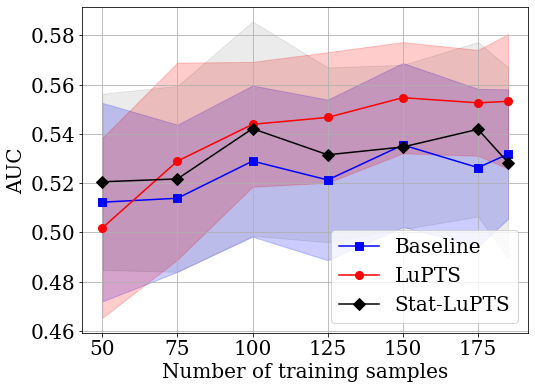

In [19]:
size_by_auc_baseline = np.zeros((len(train_size),30))
size_by_auc_lupts    = np.zeros((len(train_size),30))
size_by_auc_lupts_stat    = np.zeros((len(train_size),30))
for i,size in enumerate(train_size): 
    baseline_aucs = R[(R['size'] == size) & (R['method'] == 'baseline')]['auc'].values
    lupts_aucs = R[(R['size'] == size) & (R['method'] == 'lupts')]['auc'].values
    lupts_stat_aucs = R[(R['size'] == size) & (R['method'] == 'lupts-stat')]['auc'].values
    size_by_auc_baseline[i] = baseline_aucs; size_by_auc_lupts[i] = lupts_aucs
    size_by_auc_lupts_stat[i] = lupts_stat_aucs

fig, ax = plt.subplots(figsize=(8,6))
# ax.set_title('Results on Test Set [lin/lin] (PFS Task) [w/ 3 intermediate time points]' , fontsize=20,pad=20)
ax.set_ylabel('AUC', fontsize=20)
ax.set_xlabel('Number of training samples', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# ax.set_ylim(0.48,0.62)

ax.plot(train_size,np.mean(size_by_auc_baseline,axis=1),marker='s',ms=8,color='blue', label='Baseline')
ax.plot(train_size,np.mean(size_by_auc_lupts,axis=1),marker='o',ms=8,color='red', label='LuPTS')
ax.plot(train_size,np.mean(size_by_auc_lupts_stat,axis=1),marker='D',ms=8,color='black', label='Stat-LuPTS')
ax.fill_between(train_size,np.mean(size_by_auc_baseline,axis=1)+np.std(size_by_auc_baseline,axis=1),\
                np.mean(size_by_auc_baseline,axis=1)-np.std(size_by_auc_baseline,axis=1),alpha=0.2,color='blue')
ax.fill_between(train_size,np.mean(size_by_auc_lupts,axis=1)+np.std(size_by_auc_lupts,axis=1),\
                np.mean(size_by_auc_lupts,axis=1)-np.std(size_by_auc_lupts,axis=1),alpha=0.2,color='red')
ax.fill_between(train_size,np.mean(size_by_auc_lupts_stat,axis=1)+np.std(size_by_auc_lupts_stat,axis=1),\
                np.mean(size_by_auc_lupts_stat,axis=1)-np.std(size_by_auc_lupts_stat,axis=1),alpha=0.08,color='black')
ax.legend(fontsize=20, loc='lower right')
ax.grid()
fig.savefig('./plots/fig-tr-task-mult-wstat.pdf',bbox_inches='tight')